# Proyecto Random Forest

El objetivo de este proyecto es predecir si un paciente tiene diabetes basado en medidas diagnósticas, utilizando un modelo de random forest.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

import joblib

In [2]:
# CARGA DE DATOS
url = "https://breathecode.herokuapp.com/asset/internal-link?id=930&path=diabetes.csv"
df = pd.read_csv(url)

print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Analisis exploratorio (EDA)

In [3]:
# INFO GENERAL DEL DATASET Y ESTADÍSTICOS DESCRIPTIVOS BÁSICOS
print("INFORMACIÓN GENERAL DEL DATASET:")
print(df.info())

print("\nESTADÍSTICOS DESCRIPTIVOS BÁSICOS:")
print(df.describe())

INFORMACIÓN GENERAL DEL DATASET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

ESTADÍSTICOS DESCRIPTIVOS BÁSICOS:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.84

In [4]:
# VERIFICACION DE NULOS
print("Valores nulos por columna:")
print(df.isnull().sum())

# VERIFICACION DE DUPLICADOS
print(f"Filas duplicadas: {df.duplicated().sum()}")

Valores nulos por columna:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Filas duplicadas: 0


No hay valores nulos o duplicados en el dataset, sin embargo notamos que hay ceros en columnas como Glucose, BloodPressure, etc., que podrían ser valores inválidos (imposibles fisiológicamente). Los trataremos como missing y los imputaremos con la mediana.

In [8]:
# Reemplazar ceros inválidos con NaN
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_with_zeros:
    df[col] = df[col].replace(0, np.nan)

# Imputar con mediana
for col in cols_with_zeros:
    df[col].fillna(df[col].median(), inplace=True)

print("\nDespués de imputación:")
df.describe()


Después de imputación:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [9]:
# Distribución de la variable objetivo (%)
print("Distribución de Outcome:")
print(df['Outcome'].value_counts(normalize=True) * 100)

Distribución de Outcome:
Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64


In [10]:
# Correlación con Outcome (variable objetivo)
correlations = df.corr()['Outcome'].sort_values(ascending=False)
print("Correlaciones con Outcome:")
print(correlations)

Correlaciones con Outcome:
Outcome                     1.000000
Glucose                     0.492782
BMI                         0.312038
Age                         0.238356
Pregnancies                 0.221898
SkinThickness               0.214873
Insulin                     0.203790
DiabetesPedigreeFunction    0.173844
BloodPressure               0.165723
Name: Outcome, dtype: float64


Glucose muestra la correlación más fuerte con Outcome, seguida de BMI y Age.

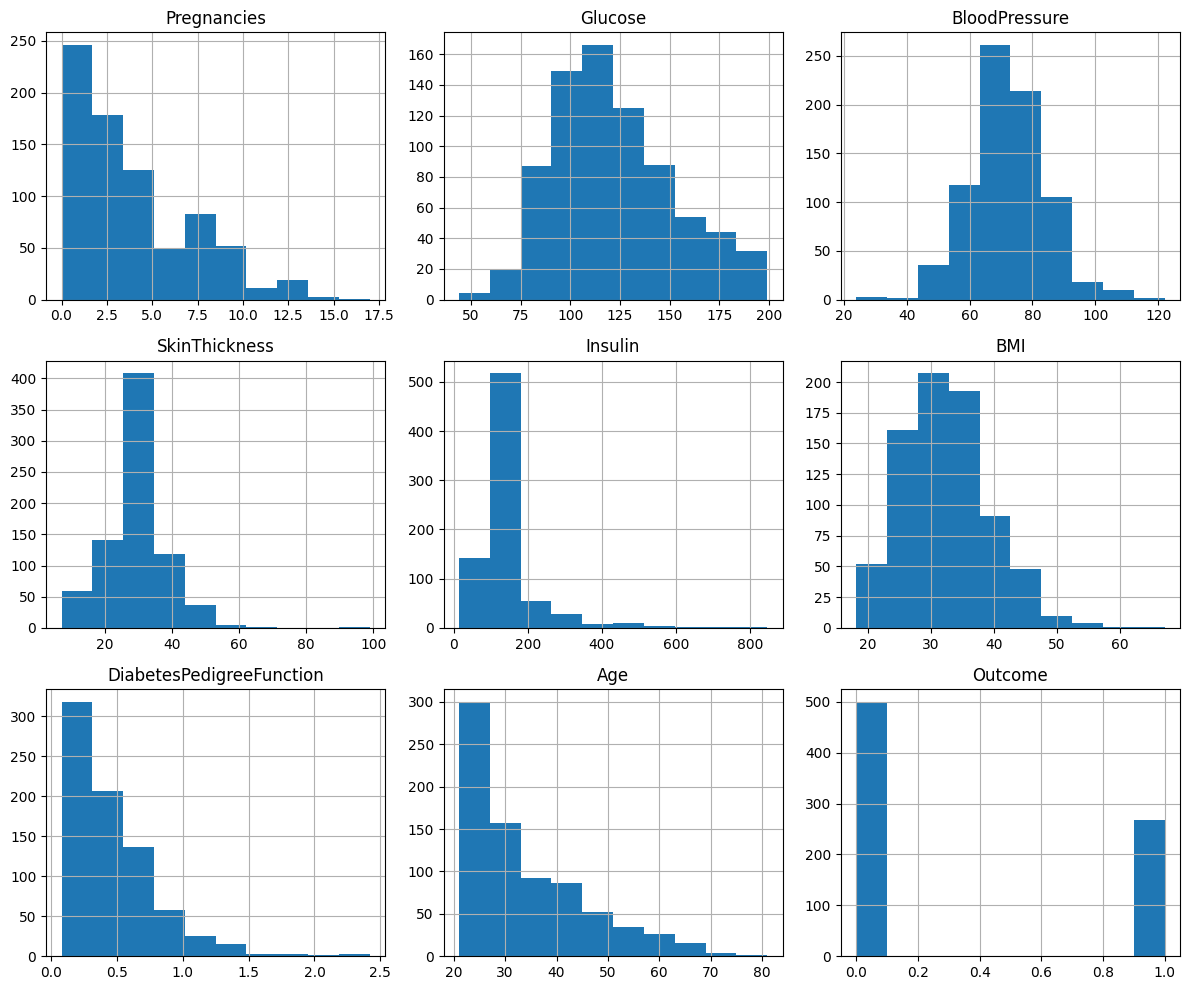

In [11]:
# Visualización: Histogramas
df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

Los histogramas muestran distribuciones; notamos sesgos en Insulin y SkinThickness.

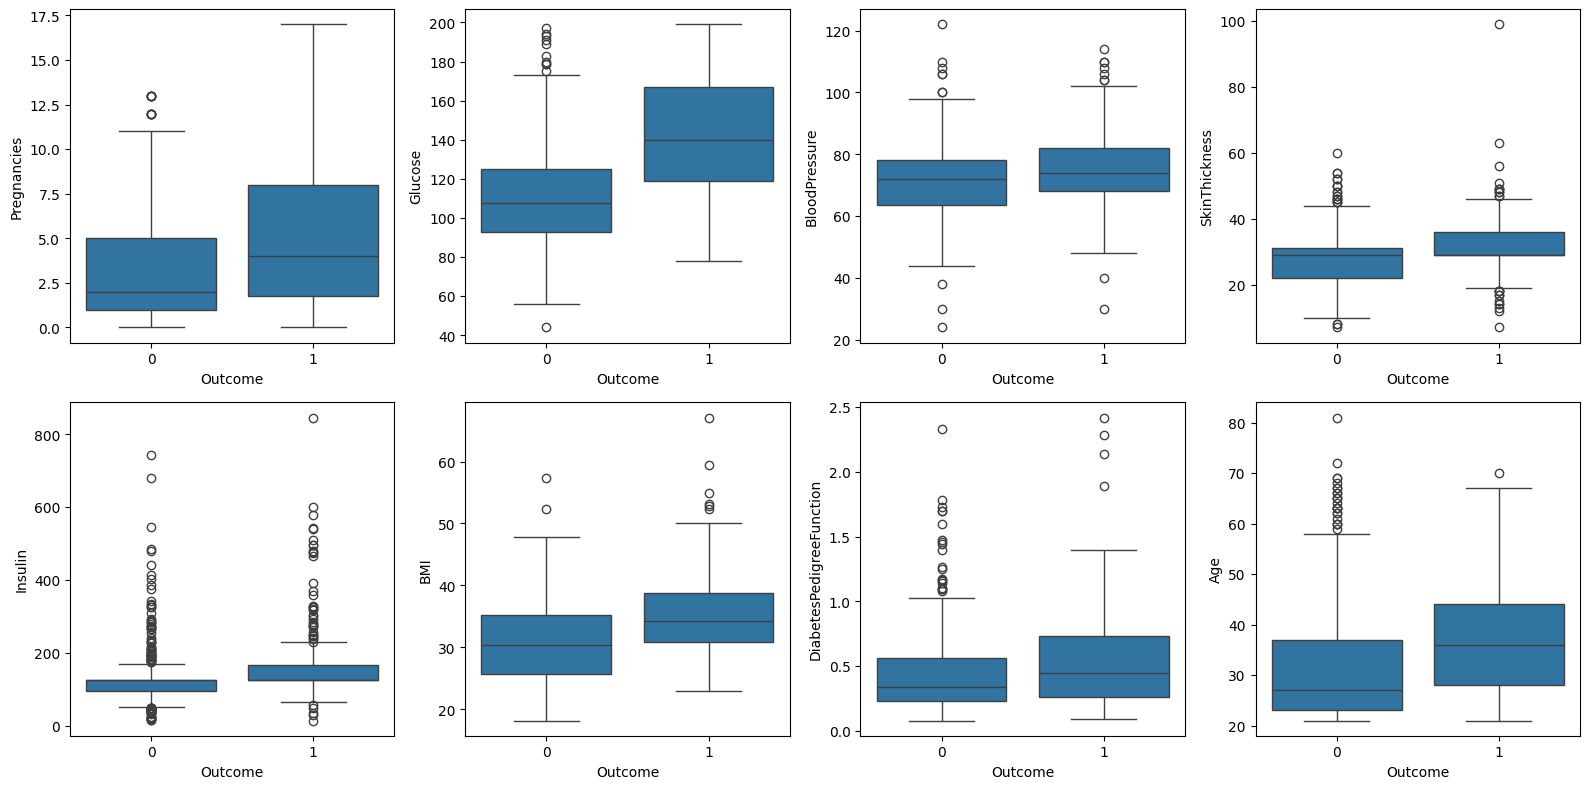

In [12]:
# Boxplots por Outcome (target)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, col in enumerate(df.columns[:-1]):
    sns.boxplot(data=df, x='Outcome', y=col, ax=axes[i//4, i%4])
plt.tight_layout()
plt.show()

Los boxplots revelan diferencias significativas en Glucose, BMI, Age entre clases. y nos dejan ver algunos outliers muy marcados.

In [13]:
# Analisis de Outliers por IQR
def count_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((col < lower) | (col > upper)).sum()

outliers_count = df.drop('Outcome', axis=1).apply(count_outliers)
print("Outliers detectados por variable:")
print(outliers_count)

Outliers detectados por variable:
Pregnancies                   4
Glucose                       0
BloodPressure                14
SkinThickness                87
Insulin                     346
BMI                           8
DiabetesPedigreeFunction     29
Age                           9
dtype: int64


Se detectan bastantes outliers, pero no son tratados porque representan valores clinicos reales que nos interesan y porque el arbol de decisión no se ve afectado por la presencia de outliers

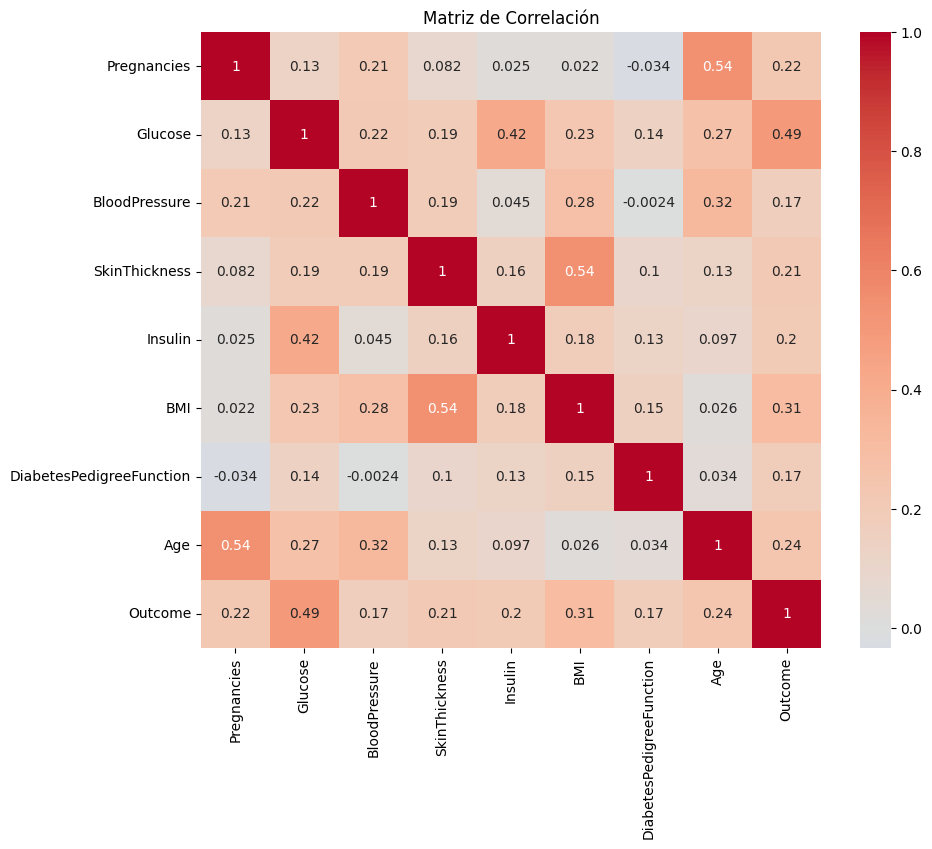

In [17]:
# Heatmap de correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Matriz de Correlación")
plt.show()

In [ ]:
No hay multicolinealidad fuerte.

In [ ]:
En este dataset no es necesario **encoding** pues todas las variables son numéricas